In [2]:
import tensorflow as tf
import librosa
import numpy as np
import IPython.display as ipd
import os
import pyaudio
import wave
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool
import matplotlib.pyplot as plt

## Loading samples

In [3]:
data = np.load('data/merged.npz')
X = data['sample']
Y = data['label']
X.shape

(3785, 20, 65, 1)

## Split into validation and train data

In [4]:
X_val = np.append(X[:120], X[-120:], axis=0)
X_train = X[120:-120]
Y_val = np.append(Y[:120], Y[-120:], axis=0)
Y_train = Y[120:-120]
X_val.shape

(240, 20, 65, 1)

## Preparing dataset

In [5]:
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).repeat().shuffle(len(X_val)).batch(32)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).repeat().shuffle(len(X_train)).batch(256)

## Preparing model

In [6]:
model = tf.keras.Sequential([
tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', input_shape=(20, 65, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax'),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [7]:
sgd = tf.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

In [8]:
# model.compile(loss='sparse_categorical_crossentropy',
#               optimizer=sgd,
#               metrics=['accuracy'])
model.compile(optimizer=sgd,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train model

In [10]:
model.fit(train_dataset, epochs=4, validation_data=val_dataset, steps_per_epoch=2, validation_steps=4)

Train for 2 steps, validate for 4 steps
Epoch 1/4
2/2 [==============================] - 2s 1s/step - loss: 0.5851 - accuracy: 0.8691 - val_loss: 0.7381 - val_accuracy: 0.4062
Epoch 2/4
2/2 [==============================] - 2s 1s/step - loss: 0.5801 - accuracy: 0.8809 - val_loss: 0.7596 - val_accuracy: 0.3438
Epoch 3/4
2/2 [==============================] - 2s 1s/step - loss: 0.5837 - accuracy: 0.8672 - val_loss: 0.7366 - val_accuracy: 0.4141
Epoch 4/4
2/2 [==============================] - 2s 1s/step - loss: 0.5833 - accuracy: 0.8652 - val_loss: 0.7453 - val_accuracy: 0.3906


## Obtaining answer

#### Recording sample

In [11]:
CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100
RECORD_SECONDS = 1.5
WAVE_OUTPUT_FILENAME = "output.wav"

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)

print("* recording ")

frames = []

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)

print("* done recording ")

stream.stop_stream()
stream.close()
p.terminate()

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

* recording 
* done recording 


#### Sample processing

In [12]:
x, sr = librosa.load(r"output.wav")
mfcc = librosa.feature.mfcc(y=x, sr=sr, hop_length=len(x)//64, n_mfcc=20)
# mfcc = mfcc.flatten()np.shape(X_other_copy)
print(mfcc.shape)

ipd.Audio(r"output.wav", rate=sr)
# "WAVE_OUTPUT_FILENAME"
#r"audiobooks/data/ru_open_stt/private_buriy_audiobooks_2/0/1d/07921cf11da9.wav"

(20, 65)


#### Model testing

In [21]:
# model.predict(X.values[2200].reshape(1, X.shape[1])
model.predict(mfcc.reshape(1, 20, 65, 1))

array([[0.38703316, 0.61296684]], dtype=float32)

#### Saving model

In [27]:
model.save('models\\64_hop_20_nmfcc_CNN_v_5.h5')

In [214]:
mfcc = X_val[3].reshape(20, 65)

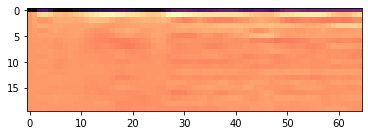

In [22]:
plt.imshow(mfcc, cmap='magma')

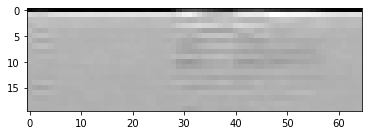

In [37]:
plt.imshow(mfcc, cmap='gray')

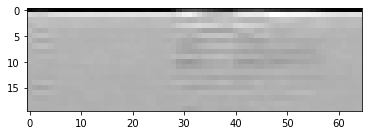

In [38]:
plt.imshow(mfcc, cmap='gray')

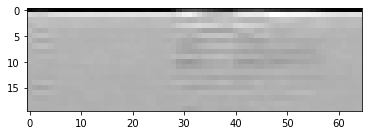

In [39]:
plt.imshow(mfcc, cmap='gray')